In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc 
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_validate, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier

In [3]:
server = #enter server name here (removed for security)
database = # enter database name here (removed for security)
cnxn=pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=Yes')

voter_data = pd.read_sql("""SELECT * from voter_sample_100k""", cnxn) 
predictit_data = pd.read_sql("""SELECT * from predictit_matched_20240206""", cnxn)

cnxn.close()

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_27184\2719086436.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  voter_data = pd.read_sql("""SELECT * from voter_sample_100k""", cnxn)
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_27184\2719086436.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  predictit_data = pd.read_sql("""SELECT * from predictit_matched_20240206""", cnxn)


In [4]:
len(voter_data)

100000

## drop records that aren't active users

In [5]:
#keep only the active users in the predictit sample

for column in ['deposits', 'accountbalance', 'Withdrawals', 'Invested', 'riskamount', 'profit', 'loss','numshares']:
    predictit_data[column] = pd.to_numeric(predictit_data[column])
    
condition = (
    (predictit_data['deposits'] != 0) |
    (predictit_data['accountbalance'] != 0) |
    (predictit_data['Withdrawals'] != 0.00) |
    (predictit_data['Invested'] != 0.00) |
    (predictit_data['numshares'] != 0) |  
    (predictit_data['riskamount'] != 0.0000) |
    (predictit_data['profit'] != 0.000000) |
    (predictit_data['loss'] != 0.000000)
)

predictit_data = predictit_data[condition].copy()

In [6]:
len(predictit_data)

89079

## create a balanced training data set of half predictit users and half random voters.

In [8]:
#note- experimented with different size training data sets, eventually used whole data set basically
predictit_sample = predictit_data.sample(n=89000, random_state=42)
voter_sample  = voter_data.sample(n=89000, random_state=42)

# Create a source column
# Set 'predictit_user' to 1 for records from predictit_data, and to 0 for records from voter_sample
predictit_sample['predictit_user'] = 1
voter_sample['predictit_user'] = 0

# Since there are some columns in predictit_data that aren't in voter_sample, align the columns
columns_to_keep = voter_sample.columns.tolist()  # This gets the column names from voter_sample
predictit_sample_aligned = predictit_sample[columns_to_keep]  # Select only the shared columns plus the new one

# Now concatenate the two DataFrames
training_data = pd.concat([predictit_sample_aligned, voter_sample], ignore_index=True)


In [9]:
len(voter_sample)

89000

In [10]:
training_data['predictit_user'].value_counts()  # this is our target variable

1    89000
0    89000
Name: predictit_user, dtype: int64

## Data Cleaning & Feature Engineering

In [11]:
#narrow down to the columns i am going to use (note, these columns are derived from the significance testing in the EDA / script

columns =['AGE','ZIP','MEDHOMEVAL','SEX','OCCDETAIL','OCCDETAIL_DESC','LIFESTAGE_CLUSTER','CNS_MEDINC','GENDER_MIX',
'CNSUS_PCTB','AGE_IND','GENERATION','TOD_SEN_R_2020','HOMEMKTVAL','TOD_SEN_D_2020',
'INCOMESTHH','TOD_SEN_D_2014','TOD_SEN_R_2014','TOD_PRES_R_2020','VP_GEN','TOD_PRES_D_2020','TOD_PRES_R_2016',
'TOD_PRES_D_2016','AUTO_MODEL','TOD_GOV_R_2018','TOD_PRES_R_2012','CNSUS_PCTA','TOD_PRES_D_2012','TOD_SEN_R_2012',
'TOD_GOV_D_2018','TOD_SEN_D_2012','TOD_SEN_R_2018','TOD_SEN_R_2016','NETWORTH','TOD_GOV_R_2014','TOD_SEN_D_2018',
'TOD_GOV_D_2014','TOD_SEN_D_2016','TOD_SEN_DIFF_2020','TOD_PRES_DIFF_2020','EDUCATION','TOD_PRES_DIFF_2016','OCCUPATION',
'WEALTH','TOD_SEN_DIFF_2014','TOD_SEN_DIFF_2016','TOD_PRES_R_2020_PREC','CNSUS_PCTW',
'PARTY_CODE','ETHNIC_INFER','VOTER_CNT','COUNTY_ST','CENSUS_ST', 'ALUMNI_INDUSTRY', 'predictit_user']

training_data = training_data[columns]


In [12]:
#Replace blanks and spaces with NaN
training_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)


In [128]:
training_data.head()

,AGE,ZIP,MEDHOMEVAL,SEX,OCCDETAIL,OCCDETAIL_DESC,LIFESTAGE_CLUSTER,CNS_MEDINC,GENDER_MIX,CNSUS_PCTB,...,TOD_SEN_DIFF_2016,TOD_PRES_R_2020_PREC,CNSUS_PCTW,PARTY_CODE,ETHNIC_INFER,VOTER_CNT,COUNTY_ST,CENSUS_ST,ALUMNI_INDUSTRY,predictit_user
0,051,55127,NaN,M,NaN,NaN,5,01642,4,0.000000,...,NaN,039.2,66.666667,S,C,29,123,27,NaN,1
1,031,76310,NaN,M,NaN,NaN,E,00833,1,0.000000,...,NaN,080.6,94.915254,S,C,1,485,48,NaN,1
2,035,60187,NaN,M,NaN,NaN,E,01035,1,1.515152,...,03D,037.0,86.363636,S,C,2,043,17,NaN,1
3,030,02919,NaN,M,NaN,NaN,1,00756,1,0.000000,...,NaN,052.8,37.037037,D,C,6,007,44,NaN,1
4,040,32607,NaN,M,NaN,NaN,NaN,NaN,1,7.218045,...,12D,026.8,75.338346,N,C,5,001,12,NaN,1


In [13]:

#consolidate SEX values due to some casing issues.
training_data['SEX'] = training_data['SEX'].replace({'f': 'F', 'm': 'M', 'N': 'U', ' ': 'U'})

# Mapping the PARTY_CODE to groups - inferred r/d as r/d etc
party_code_mapping = {
    'R': 'Republican', 'S': 'Republican',
    'D': 'Democrat', 'E': 'Democrat',
    'N': 'No Affiliation', 'U': 'Unknown'
}

# If the party code is not in the mapping, assign as other
training_data['GROUPED_PARTY'] = training_data['PARTY_CODE'].map(party_code_mapping).fillna('Other')

#create a unique county code using state code and county code
training_data['COUNTY_CODE'] = training_data['CENSUS_ST']+training_data['COUNTY_ST']

In [14]:
# Convert numeric fields to float and replace Y/ NaN with 1 / 0
for column in training_data.columns:
    # Check if all values in the column are numeric
    if training_data[column].apply(lambda x: str(x).replace('.', '', 1).isdigit()).all():
        training_data[column] = training_data[column].astype(float)
    # Check for fields where the only values are 'Y' and NaN
    elif set(training_data[column].dropna().unique()) == {'Y'}:
        training_data[column] = training_data[column].map({'Y': 1, np.nan: 0}).astype(int)
        training_data[column] = training_data[column].astype(float)

In [15]:
#impute missing values
for column in training_data.columns:
    # Check if the column is numeric
    if training_data[column].dtype in ['float64', 'int64']:
        # Fill missing values with -1
        training_data[column].fillna(-1, inplace=True)
    else:
        # Fill missing values with "UNK"
        training_data[column].fillna("UNK", inplace=True)

## Feature selection & train / test split

In [16]:
#got below list of significant columns from the EDA ... added 'PARTY_CODE','GROUPED_PARTY','ETHNIC_INFER','VOTER_CNT',
#                 'COUNTY_CODE','ALUMNI_INDUSTRY'

In [17]:
features_to_use =['AGE','ZIP','MEDHOMEVAL','SEX','OCCDETAIL','OCCDETAIL_DESC','LIFESTAGE_CLUSTER','CNS_MEDINC','GENDER_MIX',
'CNSUS_PCTB','AGE_IND','GENERATION','TOD_SEN_R_2020','HOMEMKTVAL','TOD_SEN_D_2020',
'INCOMESTHH','TOD_SEN_D_2014','TOD_SEN_R_2014','TOD_PRES_R_2020','VP_GEN','TOD_PRES_D_2020','TOD_PRES_R_2016',
'TOD_PRES_D_2016','AUTO_MODEL','TOD_GOV_R_2018','TOD_PRES_R_2012','CNSUS_PCTA','TOD_PRES_D_2012','TOD_SEN_R_2012',
'TOD_GOV_D_2018','TOD_SEN_D_2012','TOD_SEN_R_2018','TOD_SEN_R_2016','NETWORTH','TOD_GOV_R_2014','TOD_SEN_D_2018',
'TOD_GOV_D_2014','TOD_SEN_D_2016','TOD_SEN_DIFF_2020','TOD_PRES_DIFF_2020','EDUCATION','TOD_PRES_DIFF_2016','OCCUPATION',
'WEALTH','TOD_SEN_DIFF_2014','TOD_SEN_DIFF_2016','TOD_PRES_R_2020_PREC','CNSUS_PCTW','PARTY_CODE','GROUPED_PARTY','ETHNIC_INFER','VOTER_CNT',
                 'COUNTY_CODE','ALUMNI_INDUSTRY']

X = training_data[features_to_use] 
y = training_data['predictit_user']

In [18]:
#first split - validation set
X_temp, X_validation, y_temp, y_validation = train_test_split(X, y, test_size=0.1, random_state=42) # 10% for validation

#Second split: Splitting the remaining data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42) # 20% of 90% for testing

In [19]:
# Creating copies of the original datasets for CatBoost and maybe LightGBM
X_cb_lgbm = X.copy()
y_cb_lgbm = y.copy()

# First split 
X_temp_cb_lgbm, X_validation_cb_lgbm, y_temp_cb_lgbm, y_validation_cb_lgbm = train_test_split(X_cb_lgbm, y_cb_lgbm, test_size=0.1, random_state=42) # 10% for validation

# Second split
X_train_cb_lgbm, X_test_cb_lgbm, y_train_cb_lgbm, y_test_cb_lgbm = train_test_split(X_temp_cb_lgbm, y_temp_cb_lgbm, test_size=0.2, random_state=42) # 20% of 90% for testing

# One-Hot Encoding

In [20]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [21]:
#categorical_columns

In [24]:
# Create column transformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ], remainder='passthrough')  # 'passthrough' numerical features as is

# Apply  transformations
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)
X_validation_encoded = preprocessor.transform(X_validation)


# Get feature names after one-hot encoding for later use
encoded_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
# Combine with numerical features 
features_after_encoding = list(encoded_features) + [col for col in X_train.columns if col not in categorical_columns]


# Evaluate Performance Across Different Models

## Dummy Classifier

In [26]:
#train a dummy classifier

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train_encoded, y_train)
y_pred = dummy_clf.predict(X_test_encoded)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy of DummyClassifier: {accuracy}')

Baseline accuracy of DummyClassifier: 0.5020911360799001


## Logistic Regression

In [27]:
#initialize and train logistic regression model
lr_pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))
lr_pipeline.fit(X_train_encoded, y_train)

# Evaluate 
y_pred = lr_pipeline.predict(X_test_encoded)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.7380149812734083
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.73     15923
         1.0       0.74      0.75      0.74     16117

    accuracy                           0.74     32040
   macro avg       0.74      0.74      0.74     32040
weighted avg       0.74      0.74      0.74     32040



In [28]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(lr_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.724
Average Precision (macro): 0.724
Average F1-Score (macro): 0.724


In [29]:
#validation set testing
y_validation_pred = lr_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.7351685393258427
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.73      8902
         1.0       0.73      0.74      0.74      8898

    accuracy                           0.74     17800
   macro avg       0.74      0.74      0.74     17800
weighted avg       0.74      0.74      0.74     17800



## Support Vector Machine

In [30]:

# Initialize / train SVM model
svm_pipeline = make_pipeline(StandardScaler(with_mean=False), SVC(max_iter=10000))
svm_pipeline.fit(X_train_encoded, y_train)

# Evaluate 
y_pred = svm_pipeline.predict(X_test_encoded)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Set Evaluation:
Accuracy: 0.6526841448189763
              precision    recall  f1-score   support

         0.0       0.69      0.54      0.61     15923
         1.0       0.63      0.76      0.69     16117

    accuracy                           0.65     32040
   macro avg       0.66      0.65      0.65     32040
weighted avg       0.66      0.65      0.65     32040



In [31]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(svm_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or

5-Fold Cross-Validation Results:
Average Accuracy: 0.649
Average Precision (macro): 0.662
Average F1-Score (macro): 0.642


In [32]:
#validation set testing
y_validation_pred = svm_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.6544943820224719
              precision    recall  f1-score   support

         0.0       0.69      0.55      0.61      8902
         1.0       0.63      0.76      0.69      8898

    accuracy                           0.65     17800
   macro avg       0.66      0.65      0.65     17800
weighted avg       0.66      0.65      0.65     17800



## Random Forest

In [33]:

# Initialize / train  Random Forest model
rf_pipeline = RandomForestClassifier()
rf_pipeline.fit(X_train_encoded, y_train)

# Evaluate 
y_pred_rf = rf_pipeline.predict(X_test_encoded)
print("Random Forest Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Model Test Set Evaluation:
Accuracy: 0.7815543071161049
              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78     15923
         1.0       0.78      0.79      0.78     16117

    accuracy                           0.78     32040
   macro avg       0.78      0.78      0.78     32040
weighted avg       0.78      0.78      0.78     32040



In [220]:
# 5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(rf_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.780
Average Precision (macro): 0.780
Average F1-Score (macro): 0.780


In [34]:
#validation set testing
y_validation_pred = rf_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.7852808988764045
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      8902
         1.0       0.78      0.79      0.79      8898

    accuracy                           0.79     17800
   macro avg       0.79      0.79      0.79     17800
weighted avg       0.79      0.79      0.79     17800



## Gradient Boosting Classifier

In [35]:

# Initialize and train the GradientBoostingClassifier

gbdt_pipeline =  GradientBoostingClassifier()
gbdt_pipeline.fit(X_train_encoded, y_train)

# Evaluate
y_pred_gbdt = gbdt_pipeline.predict(X_test_encoded)
print("Gradient Boosted Decision Tree Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbdt))
print(classification_report(y_test, y_pred_gbdt))

Gradient Boosted Decision Tree Model Test Set Evaluation:
Accuracy: 0.7819288389513108
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78     15923
         1.0       0.78      0.80      0.79     16117

    accuracy                           0.78     32040
   macro avg       0.78      0.78      0.78     32040
weighted avg       0.78      0.78      0.78     32040



In [223]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(gbdt_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

#  evaluation metrics across  5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.783
Average Precision (macro): 0.783
Average F1-Score (macro): 0.783


In [36]:
#validation set testing
y_validation_pred = gbdt_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.784438202247191
              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      8902
         1.0       0.78      0.80      0.79      8898

    accuracy                           0.78     17800
   macro avg       0.78      0.78      0.78     17800
weighted avg       0.78      0.78      0.78     17800



## XGBoost

In [37]:

# Initialize and train  XGBoost model
xgb_pipeline = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_pipeline.fit(X_train_encoded, y_train)

# Evaluate 
y_pred_xgb = xgb_pipeline.predict(X_test_encoded)
print("XGBoost Model Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Model Test Set Evaluation:
Accuracy: 0.7912921348314607
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79     15923
         1.0       0.79      0.80      0.80     16117

    accuracy                           0.79     32040
   macro avg       0.79      0.79      0.79     32040
weighted avg       0.79      0.79      0.79     32040



In [38]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(xgb_pipeline, X_train_encoded, y_train, cv=5, scoring=scoring)

# metrics across 5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

5-Fold Cross-Validation Results:
Average Accuracy: 0.791
Average Precision (macro): 0.791
Average F1-Score (macro): 0.791


In [39]:
#validation set testing
y_validation_pred = xgb_pipeline.predict(X_validation_encoded)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.7915730337078651
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      8902
         1.0       0.78      0.80      0.79      8898

    accuracy                           0.79     17800
   macro avg       0.79      0.79      0.79     17800
weighted avg       0.79      0.79      0.79     17800



## CatBoost

Okay , this model uses categorical columns without encoding, so feeding it a copy of the training/ test data that did not go through label encoding.

In [40]:

cat_features_indices = [X_train_cb_lgbm.columns.get_loc(c) for c in categorical_columns if c in X_train_cb_lgbm]

cat_model = CatBoostClassifier(iterations=1000, 
                               learning_rate=0.1, 
                               depth=10,
                               cat_features=cat_features_indices,
                               verbose=100)

# Train CatBoost model
cat_model.fit(X_train_cb_lgbm, y_train_cb_lgbm)

# Evaluate 
y_pred_cat = cat_model.predict(X_test_cb_lgbm)
print("CatBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test_cb_lgbm, y_pred_cat))
print(classification_report(y_test_cb_lgbm, y_pred_cat))


0:	learn: 0.6468770	total: 3.46s	remaining: 57m 39s
100:	learn: 0.4129291	total: 5m 15s	remaining: 46m 51s
200:	learn: 0.3802761	total: 10m 38s	remaining: 42m 18s
300:	learn: 0.3578337	total: 16m 17s	remaining: 37m 49s
400:	learn: 0.3397464	total: 21m 39s	remaining: 32m 20s
500:	learn: 0.3211038	total: 26m 55s	remaining: 26m 49s
600:	learn: 0.3025305	total: 32m 59s	remaining: 21m 54s
700:	learn: 0.2864381	total: 38m 16s	remaining: 16m 19s
800:	learn: 0.2719182	total: 43m 39s	remaining: 10m 50s
900:	learn: 0.2577956	total: 49m 12s	remaining: 5m 24s
999:	learn: 0.2440150	total: 54m 46s	remaining: 0us
CatBoost Test Set Evaluation:
Accuracy: 0.7983458177278402
              precision    recall  f1-score   support

         0.0       0.80      0.79      0.79     15923
         1.0       0.79      0.81      0.80     16117

    accuracy                           0.80     32040
   macro avg       0.80      0.80      0.80     32040
weighted avg       0.80      0.80      0.80     32040



In [41]:
#validation set testing
y_validation_pred = cat_model.predict(X_validation_cb_lgbm)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.7984831460674158
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      8902
         1.0       0.79      0.81      0.80      8898

    accuracy                           0.80     17800
   macro avg       0.80      0.80      0.80     17800
weighted avg       0.80      0.80      0.80     17800



In [49]:
#  5-fold cross-validation
scoring = {'accuracy': 'accuracy', 'precision': 'precision_macro', 'f1': 'f1_macro'}
cv_results = cross_validate(cat_model, X_train_cb_lgbm, y_train_cb_lgbm, cv=5, scoring=scoring)

# evaluation metrics across 5 folds
print("5-Fold Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average Precision (macro): {np.mean(cv_results['test_precision']):.3f}")
print(f"Average F1-Score (macro): {np.mean(cv_results['test_f1']):.3f}")

0:	learn: 0.6472879	total: 2.35s	remaining: 39m 13s
100:	learn: 0.4088572	total: 4m 38s	remaining: 41m 20s
200:	learn: 0.3774227	total: 10m 1s	remaining: 39m 49s
300:	learn: 0.3516770	total: 15m 17s	remaining: 35m 29s
400:	learn: 0.3313755	total: 20m 18s	remaining: 30m 19s
500:	learn: 0.3111712	total: 25m 33s	remaining: 25m 26s
600:	learn: 0.2898593	total: 30m 48s	remaining: 20m 27s
700:	learn: 0.2722759	total: 36m 29s	remaining: 15m 33s
800:	learn: 0.2567562	total: 44m 33s	remaining: 11m 4s
900:	learn: 0.2418122	total: 52m 49s	remaining: 5m 48s
999:	learn: 0.2274639	total: 59m 11s	remaining: 0us
0:	learn: 0.6488450	total: 2.93s	remaining: 48m 50s
100:	learn: 0.4066616	total: 6m	remaining: 53m 27s
200:	learn: 0.3779134	total: 12m 45s	remaining: 50m 44s
300:	learn: 0.3546718	total: 18m 21s	remaining: 42m 37s
400:	learn: 0.3313861	total: 23m 53s	remaining: 35m 41s
500:	learn: 0.3113814	total: 29m 24s	remaining: 29m 17s
600:	learn: 0.2949731	total: 35m 29s	remaining: 23m 34s
700:	learn: 0

## Hyper-parameter Tuning with CatBoost

In [50]:
#let's try a grid search for parameter tuning

cat_model = CatBoostClassifier(verbose=100, cat_features=cat_features_indices)

# Define the parameter grid 
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'depth': [6, 10]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=cat_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy',
                           verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train_cb_lgbm, y_train_cb_lgbm)

# Print the best parameters found by the grid search
print("Best parameters found by grid search:", grid_search.best_params_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred_cat = best_model.predict(X_test_cb_lgbm)

print("CatBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test_cb_lgbm, y_pred_cat))
print(classification_report(y_test_cb_lgbm, y_pred_cat))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 0.6719008	total: 905ms	remaining: 7m 31s
100:	learn: 0.4518594	total: 1m 33s	remaining: 6m 9s
200:	learn: 0.4436898	total: 3m 11s	remaining: 4m 45s
300:	learn: 0.4382890	total: 4m 53s	remaining: 3m 13s
400:	learn: 0.4348028	total: 6m 41s	remaining: 1m 39s
499:	learn: 0.4323864	total: 8m 28s	remaining: 0us
[CV 1/5] END depth=6, iterations=500, learning_rate=0.05;, score=0.799 total time= 8.6min
0:	learn: 0.6720170	total: 940ms	remaining: 7m 48s
100:	learn: 0.4519204	total: 1m 41s	remaining: 6m 40s
200:	learn: 0.4438799	total: 3m 23s	remaining: 5m 2s
300:	learn: 0.4385272	total: 5m 8s	remaining: 3m 24s
400:	learn: 0.4346404	total: 6m 56s	remaining: 1m 42s
499:	learn: 0.4320563	total: 8m 36s	remaining: 0us
[CV 2/5] END depth=6, iterations=500, learning_rate=0.05;, score=0.801 total time= 8.7min
0:	learn: 0.6718916	total: 839ms	remaining: 6m 58s
100:	learn: 0.4505095	total: 1m 36s	remaining: 6m 21s
200:	learn: 0.4420587	

In [ ]:
#Best parameters found: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}

In [51]:
#validation set testing using those params
y_validation_pred = best_model.predict(X_validation_cb_lgbm)
print("Validation Set Evaluation:")
print("Accuracy:", accuracy_score(y_validation, y_validation_pred))
print(classification_report(y_validation, y_validation_pred))

Validation Set Evaluation:
Accuracy: 0.802191011235955
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      8902
         1.0       0.80      0.81      0.80      8898

    accuracy                           0.80     17800
   macro avg       0.80      0.80      0.80     17800
weighted avg       0.80      0.80      0.80     17800



In [ ]:
#the grid search ran for like 18 hours and didn't help too much :)

## Check Learning Curve so we can see what optimal training dataset size is

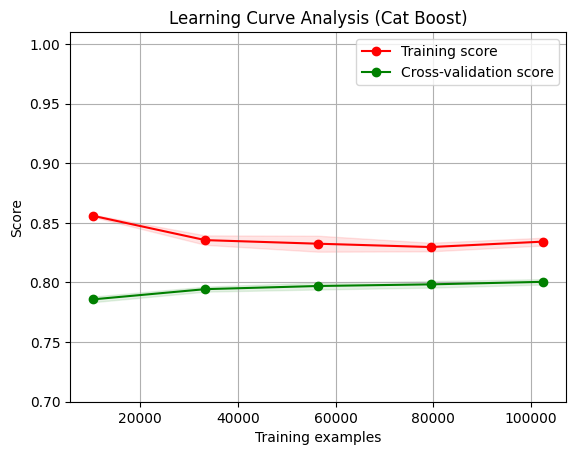

In [52]:
#Note - CHatGPT helped with learning curve code.

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curve Analysis (Cat Boost)"
# Cross-validation with 5 splits
cv = 5
# Evaluate score on training and test set several times with different training set sizes
plot_learning_curve(best_model, title, X_train_cb_lgbm, y_train_cb_lgbm, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()


In [ ]:
#looks like adding more training data may help a little but not much, looks like it gets pretty flat.


## Feature Importances

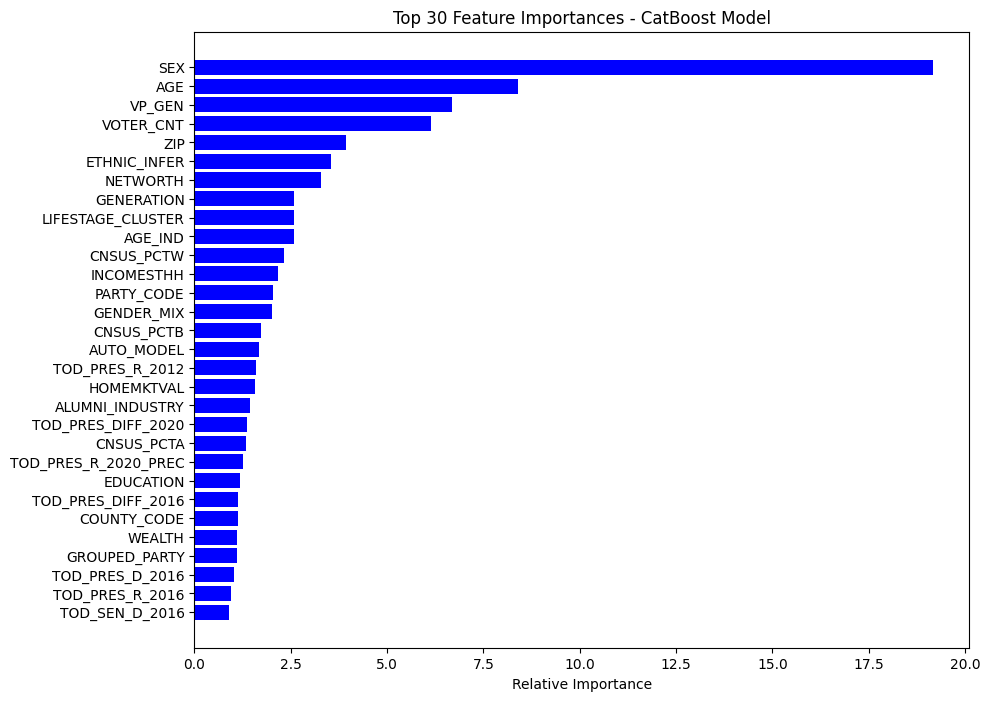

In [58]:

# Get feature importances
feature_importances = best_model.get_feature_importance()

# Get the names of the features
feature_names = X_train_cb_lgbm.columns

# Sort the feature importances and get the top 30
sorted_indices = np.argsort(feature_importances)[::-1][:30]

# plot
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances - CatBoost Model")
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], color='b', align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.gca().invert_yaxis()  #most important feature at the top
plt.xlabel('Relative Importance')
plt.show()


OK this makes sense, seems like we're definitely going after some white/ asian males of a certain age, income, geo , voting propensity

## ROC AUC Curve

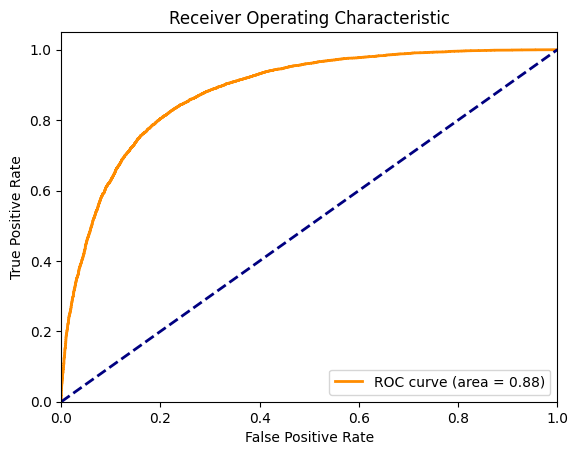

In [56]:
#Roc-AUC curve

y_scores = best_model.predict_proba(X_validation_cb_lgbm)[:, 1]
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_validation, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# doesn't look too bad.

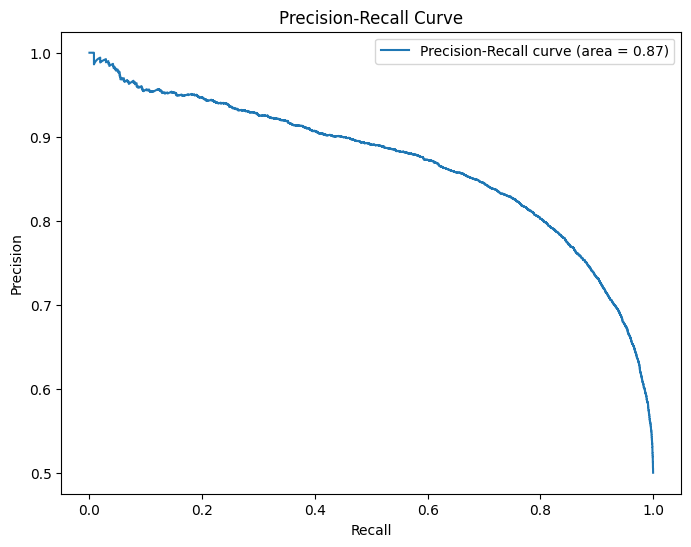

In [57]:

# Get the probability scores 
y_scores = best_model.predict_proba(X_validation_cb_lgbm)[:, 1]

# Calculate precision and recall 
precision, recall, thresholds = precision_recall_curve(y_validation, y_scores)

# Calculate the area under the curve
auc_precision_recall = auc(recall, precision)

# Plot 
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_precision_recall:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()
